# **DIVE INTO CODE COURSE**
## **Sprint Deep Learning - Convolution Neural Network**
**Student Name**: Doan Anh Tien<br>
**Student ID**: 1852789<br>
**Email**: tien.doan.g0pr0@hcmut.edu.vn

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import random
from math import log2
from sklearn.metrics import accuracy_score

plt.style.use('ggplot')

### **[Problem 1] Creating a one-dimensional convolutional layer class that limits the number of channels to one**

In [122]:
class ConVo1D:
  
  def forward_propagate(self, x, w, b):
    # Output value (which will converted to np.array)
    a = []
    for i in range(len(w)-1):
      a.append(np.matmul(x[i:i+len(w)], w) + b[0])

    return np.array(a)

  def backward_propagate(self, x, w, da):
    """
    The backward propagate intends to find three factors:
    dw, db and dx

    dw, db: 
      Using the formula similar to DNN model

    dx:
      Using the weight value multiply with the derivative of activate function da

    """
    # Calculate db
    db = np.sum(da)

    # Calculate dw
    dw = []
    for i in range(len(w)):
      dw.append(np.matmul(da, x[i:i+len(da)]))
    dw = np.array(dw)

    # Calculate dx
    dx = []
    # Adding all the shared errors
    # The errors lies in the two heads of array (j - s < 0) and (j - s > N - 1)
    new_w = np.insert(w[::-1], 0, 0) # Reverse the weight array
    new_w = np.append(new_w, 0)
    for i in range(len(new_w) - 1):
      dx.append(np.matmul(da, new_w[i:i+len(da)]))
    dx = np.array(dx[::-1]) # Reverse again

    return dw, db, dx

### **[Problem 2] Output size calculation after one-dimensional convolution**
The function will take in the size of input and perform the convolution operation, along with other parameters stride and padding, to get the size of output

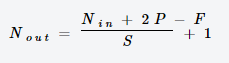

In [123]:
def output_size_calculation(n_in, F, P=0, S=1):
  n_out = int((n_in + 2*P - F)/S + 1)
  return n_out

### **[Problem 3] Experiment of one-dimensional convolutional layer with small array**

In [124]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
da = np.array([10, 20])

In [125]:
C1D = ConVo1D()
dw, db, dx = C1D.backward_propagate(x, w, da)

print("Forward: ", C1D.forward_propagate(x, w, b))
print("dw: ", dw)
print("db: ", db)
print("dx: ", dx)

Forward:  [35 50]
dw:  [ 50  80 110]
db:  30
dx:  [ 30 110 170 140]


### **[Problem 4] Creating a one-dimensional convolutional layer class that does not limit the number of channels**

**Testing the numpy pad function**

In [126]:
x = np.ones((3, 3))
y = np.pad(x, pad_width=((0,0), (2,0)))
y

array([[0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.]])

In [127]:
class ConVo1DFull:
  
  def __init__(self, filter_size, initializer, optimizer, channels_in = 1, channels_out = 1, pad=0):
    self.filter_size = filter_size
    self.optimizier = optimizer
    self.channels_in = channels_in
    self.channels_out = channels_out
    self.n_out = None
    self.pad = pad
    self.W = initializer.W(channels_out, channels_in, filter_size)
    self.B = initializer.B(channels_out)

  def forward_propagate(self, X):
    self.n_in = X.shape[-1]
    self.n_out = output_size_calculation(self.n_in, self.filter_size, self.pad)

    X = X.reshape(self.channels_in, self.n_in)
    self.X = np.pad(X, ((0,0), ((self.filter_size-1), 0)))
    self.X1 = np.zeros((self.channels_in, self.filter_size, self.n_in + (self.filter_size - 1)))

    for i in range(self.filter_size):
      self.X1[:, i] = np.roll(self.X, -i , axis=1)

    A = np.sum(self.X1[:, :, self.filter_size -1 - self.pad:self.n_in + self.pad]*self.W[:, :, :, np.newaxis], axis=(1,2)) + self.B.reshape(-1, 1)

    return A

  def backward_propagate(self, dA):
    
    self.dW = np.sum(np.dot(dA, self.X1[:, :, self.filter_size - 1 - self.pad:self.n_in + self.pad, np.newaxis]), axis=-1)
    self.dB = np.sum(dA, axis=1)
    self.dA = np.pad(dA, ((0,0), (0, (self.filter_size - 1))))
    self.dA1 = np.zeros((self.channels_out, self.filter_size, self.dA.shape[-1]))

    for i in range(self.filter_size):
      self.dA1[:, i] = np.roll(self.dA, i , axis=1)

    dX = np.sum(np.matmul(self.W, self.dA1), axis=0)
    self.optimizer.update(self)

    return dX

In [128]:
convo_test_model = ConVo1DFull(filter_size=3, initializer=WeightInitializer(0.01), optimizer=SGD(0.01), channels_in=2, channels_out=3, pad=0)

In [129]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])

# Array shapes: (channels_in, channels_out, filter_size)
convo_test_model.W = np.ones((3,2,3), dtype=float)
convo_test_model.b = np.array([1,2,3], dtype=float)

In [130]:
convo_test = convo_test_model.forward_propagate(x)
print("Results of forward \n", convo_test)

Results of forward 
 [[16. 22.]
 [17. 23.]
 [18. 24.]]


### **[Problem 7] (Advance assignment) Arbitrary number of strides**

In [156]:
class ConVo1DFullStride:
  
  def __init__(self, filter_size, initializer, optimizer, channels_in = 1, channels_out = 1, pad = 0, stride = 1):
    self.filter_size = filter_size
    self.optimizer = optimizer
    self.channels_in = channels_in
    self.channels_out = channels_out
    self.n_out = None
    self.pad = pad
    self.stride = stride
    self.W = initializer.W(channels_out, channels_in, filter_size)
    self.B = initializer.b(channels_out)

  def forward_propagate(self, X):
    self.n_sample = X.shape[0]
    self.n_in = X.shape[-1]
    self.n_out = output_size_calculation(self.n_in, self.filter_size, self.pad, self.stride)

    X = X.reshape(self.n_sample, self.channels_in, self.n_in)
    self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
    self.X1 = np.zeros((self.n_sample, self.channels_in, self.filter_size, self.n_in + (self.filter_size - 1)))

    for i in range(self.filter_size):
      self.X1[:, :, i] = np.roll(self.X, -i , axis=1)

    A = np.sum(self.X1[:, np.newaxis, :, :, self.filter_size -1 - self.pad:self.n_in + self.pad:self.stride]*self.W[:, :, :, np.newaxis], axis=(2,3)) + self.B.reshape(-1, 1)

    return A

  def backward_propagate(self, dA):
    
    self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pad:self.n_in+self.pad:self.stride], axis=(0,-1))
    self.dB = np.sum(dA, axis=(0, -1))
    self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.filter_size - 1))))
    self.dA1 = np.zeros((self.n_sample, self.channels_out, self.filter_size, self.dA.shape[-1]))

    for i in range(self.filter_size):
      self.dA1[:, :, i] = np.roll(self.dA, i , axis=-1)

    dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
    self.optimizer.update(self)

    return dX

### **[Problem 8] Learning and estimation**

**Dataset Preparation**

In [132]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [133]:
print(X_train.shape) # (60000, 28, 28)
print(y_train.shape) # (10000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(y_test.shape)
print(X_train[0].dtype) # uint8

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
uint8


**Smoothing**

In [134]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

**Visualization**

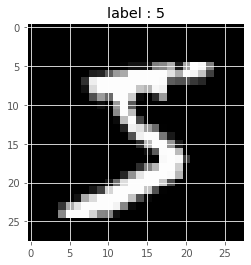

In [135]:
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

**Preprocessing**

In [136]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [137]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print("Original label: {}".format(y_train.shape)) # (60000,)
print("One hot train label: {}".format(y_train_one_hot.shape)) # (60000, 10)
print("One hot test label: {}".format(y_test_one_hot.shape))

Original label: (60000,)
One hot train label: (60000, 10)
One hot test label: (10000, 10)


In [138]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("Train data: ", X_train.shape)
print("Validation data: ", X_val.shape)
print("Train label: ", y_train.shape)
print("Validation label: ", y_val.shape)

Train data:  (48000, 784)
Validation data:  (12000, 784)
Train label:  (48000, 10)
Validation label:  (12000, 10)


**Neural Network Class**

In [139]:

class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]   

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [140]:
class XavierInitializer:
    """
    Xavier Initializer

    """
    def __init__(self, n_nodes1):
        self.sigma = 1.0 / n_nodes1**(1/2)

    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization

        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        Bias initialization

        """
        return self.sigma * np.random.randn(n_nodes2)

In [141]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution

    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def W(self, *shape):
        """
        Weight initialization

        """
        return self.sigma * np.random.randn(*shape)

    def b(self, *shape):
        """
        Bias initialization

        """
        return self.sigma * np.random.randn(*shape)

In [142]:
class HeInitializer:
    def __init__(self, n_nodes1):
        self.sigma = (2.0 / n_nodes1)**(1/2)

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)

In [143]:
class ReLU:
    def forward(self, A):
        return np.maximum(A, 0)
    
    def backward(self, dZ, Z):
        return dZ * (Z > 0)

In [144]:
class Softmax:
    def forward(self, A):
        self.Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return self.Z
    
    def backward(self, y):
        self.loss = self.loss_function(y)
        return self.Z - y

    def loss_function(self, Y, Z=None):
        if Z is None:
          Z = self.Z
        # Adding 1e-7 for avoiding zero division
        return (-1) * np.average(np.sum(Y * np.log(Z+1e-7), axis=1))

In [145]:
class Tanh:
  def forward(self, A):
    self.A = A
    return np.tanh(A)

  def backward(self, dZ):
    return dZ * (1 - (np.tanh(self.A))**2)

In [146]:
class Sigmoid:
  def forward(self, A):
    self.A = A
    return self.sigmoid(A)

  def backward(self, dZ):
    _sig = self.sigmoid(self.A)
    return dZ * (1 - _sig)*_sig

  def sigmoid(self, X):
    return 1 / (1 + np.exp(-X))

In [147]:
class SGD:
    def __init__(self, lr):
      self.lr = lr
    
    def update(self, layer):
      layer.W -= self.lr * layer.dW
      layer.B -= self.lr * layer.dB
      return

In [148]:
class AdaGrad:
    def __init__(self, lr):
      self.lr = lr
      self.HW = 1
      self.HB = 1
    
    def update(self, layer):
      self.HW -= layer.dW**2
      self.HB -= layer.dB**2
      layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
      layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB
      return

In [153]:
class FullyC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: object
      Instance of initialization method
    optimizer: object
      Instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # Initialize
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        """
        Forward Propagation

        """       
        self.X = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        """
        Backward Propagation

        """
        self.dA = dA
        dZ = dA @ self.W.T
        self.dW = self.X.T @ dA
        self.dB = np.sum(dA, axis=0)
        # update
        self = self.optimizer.update(self)
        return dZ

In [161]:
class Scratch1dCNNClassifier():
    """
    Convolution neural network classifier with configurable structure
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, verbose=True, activator=Tanh, optimizer=AdaGrad):
      self.num_epoch = num_epoch
      self.lr = lr
      self.batch_size = batch_size
      self.n_features = n_features
      self.n_nodes1 = n_nodes1
      self.n_nodes2 = n_nodes2
      self.n_output = n_output
      self.activator = activator
      if activator == Sigmoid or activator == Tanh:
        self.initializer = XavierInitializer(self.n_nodes1)
      elif activator == ReLU:
        self.initializer = HeInitializer(self.n_nodes1)

      self.optimizer = optimizer

    def fit(self, X, y, X_val=None, y_val=None):
      self.val_enable = False
      if X_val is not None:
        self.val_enable = True

      self.Conv1d_Strides = ConVo1DFullStride(filter_size=7, initializer=SimpleInitializer(0.01), optimizer=self.optimizer(self.lr), channels_in=1, channels_out=1, pad=3, stride=2)
      self.Conv1d_Strides.n_out = output_size_calculation(X.shape[-1], self.Conv1d_Strides.filter_size, self.Conv1d_Strides.pad, self.Conv1d_Strides.stride)
      self.activation1 = self.activator()
      self.FC2 = FullyC(self.Conv1d_Strides.n_out, self.n_nodes2, self.initializer, self.optimizer(self.lr))
      self.activation2 = self.activator()
      self.FC3 = FullyC(self.n_nodes2, self.n_output, self.initializer, self.optimizer(self.lr))
      self.activation3 = Softmax()

      self.loss = []
      self.loss_epoch = [self.activation3.loss_function(y, self.forward_propagation(X))]

      for _ in range(self.num_epoch):
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
        self.iter = len(get_mini_batch)
        for mini_X, mini_y in get_mini_batch:
          self.forward_propagation(mini_X)
          self.backward_propagation(mini_X, mini_y)
          self.loss.append(self.activation3.loss)
        self.loss_epoch.append(self.activation3.loss_function(y, self.forward_propagation(X)))

    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)

    def forward_propagation(self, X):
        A1 = self.Conv1d_Strides.forward_propagate(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3

    def backward_propagation(self, X, y_true):
        dA3 = self.activation3.backward(y_true)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.Conv1d_Strides.backward_propagate(dA1)

**Model 1**

Number of hidden layers: 3

Layers size: [784, 400, 400, 10]

Batch size: 20

Learning rate: 0.01

Number of epochs: 20

Hidden layer estimator: Tanh

Output layer estimator: Softmax


In [162]:
test = Scratch1dCNNClassifier(num_epoch=20, lr=0.01, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=400, n_output=10, verbose=True)
test.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


In [163]:
y_pred = test.predict(X_test)
accuracy_score(y_test, y_pred)

0.098